In [1]:
import os
import torch
import sys, pathlib
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification,DebertaV2ForSequenceClassification, GPTNeoXForCausalLM
from llm_blender.pair_ranker.pairrm import DebertaV2PairRM
from transformers import DataCollatorWithPadding
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import re
import yaml

LOCAL_TRL_PARENT = "/workspace/Self_play_DRPO"
if LOCAL_TRL_PARENT not in sys.path:
    sys.path.insert(0, LOCAL_TRL_PARENT)

    
# now the import will use your local copy:
from trl import (
    DPOTrainer,
    DPOConfig,
    ModelConfig,
    DRPOTrainer,
    DRPOConfig,
)
from trl.trainer.utils import SIMPLE_CHAT_TEMPLATE
from trl.trainer.utils import pad, truncate_right, selective_log_softmax
from trl.data_utils import apply_chat_template

data_cache_path = "/workspace/dataset"
model_cache_path = '/workspace/model_cache'
ref_policy_path = "Qwen/Qwen2.5-1.5B-Instruct" 
#target_policy_path = "Qwen/Qwen2.5-1.5B-Instruct" 
target_policy_400_path = 'august66/hh_qwen1.5_drpo_400'
target_policy_800_path = 'august66/hh_qwen1.5_drpo_800'
dpo_policy_path = 'august66/hh_qwen_1.5b_dpo_model_2'
#reward_model_path = 'cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr'
ds_path = 'august66/drpo_hh_qwen2.5_1.5b'


def load_model(model_path, task = 'generation', model_type = 'decoder', model_cache_path =  '/workspace/model_cache'):

    model_args = ModelConfig(model_path)
    #model_torch_dtype = (model_args.torch_dtype if model_args.torch_dtype in ["auto", None] else getattr(torch, model_args.torch_dtype))
    model_torch_dtype = torch.bfloat16 
    model_kwargs = dict(
    revision = model_args.model_revision,
    torch_dtype = model_torch_dtype, 
    trust_remote_code = model_args.trust_remote_code,
    )

    padding_side = 'left' if model_type == 'decoder' else 'right'
    truncation_side = 'left' if model_type == 'decoder' else 'right'

    if task == 'generation':
        model_instance = AutoModelForCausalLM.from_pretrained(
            model_args.model_name_or_path,
            **model_kwargs,
            cache_dir = model_cache_path,
        )

    elif task == 'reward':
        model_instance = AutoModelForSequenceClassification.from_pretrained(
            model_args.model_name_or_path,
            **model_kwargs,
            cache_dir = model_cache_path,
        )
    

    model_tokenizer = AutoTokenizer.from_pretrained(
        model_args.model_name_or_path, 
        padding_side = padding_side, 
        truncation_side = truncation_side,
        use_fast = True,
        trust_remote_code = model_args.trust_remote_code,
        cache_dir = model_cache_path
    )

    if model_tokenizer.pad_token is None:
        model_tokenizer.pad_token = model_tokenizer.eos_token

    if getattr(model_instance.config, "pad_token_id", None) is None:
        model_instance.config.pad_token_id = model_tokenizer.pad_token_id

    if model_tokenizer.eos_token is None:
        model_tokenizer.eos_token = model_tokenizer.pad_token  

    if getattr(model_instance.config, "eos_token_id", None) is None:
        model_instance.config.eos_token_id = model_tokenizer.eos_token_id

    return model_instance, model_tokenizer


def generate_responses(
    model_instance,
    model_tokenizer,
    prompts,                      # single chat or list of chats (each: list[{role,content}])
    *,
    temperature=1.0,
    max_new_tokens=256,
    n_responses_total=1000,       # total per prompt
    responses_per_call=16,        # per subcall per prompt
    batch_size=4,                 # prompts per batch
    device='cuda',
    max_length=1024,
):
    # tokenizer prefs
    model_tokenizer.padding_side = "left"
    if hasattr(model_tokenizer, "truncation_side"):
        model_tokenizer.truncation_side = "left"
    if model_tokenizer.pad_token_id is None and model_tokenizer.eos_token_id is not None:
        model_tokenizer.pad_token_id = model_tokenizer.eos_token_id

    gen_kwargs = {
        "do_sample": bool(temperature > 0),
        "temperature": float(temperature),
        "top_k": 50,
        "top_p": 0.9,
        "max_new_tokens": max_new_tokens,
        "eos_token_id": model_tokenizer.eos_token_id,
        "pad_token_id": model_tokenizer.pad_token_id,
        "use_cache": True,
        "return_dict_in_generate": False,
        "output_scores": False,
        "output_attentions": False,
        "output_hidden_states": False,
    }

    # normalize prompts input
    if isinstance(prompts, str):
        prompts = [prompts]
    elif (isinstance(prompts, list) and prompts
          and isinstance(prompts[0], dict) and "role" in prompts[0]):
        prompts = [prompts]

    model_instance.to(device).eval()

    prompts_out, completions_out = [], []

    for s in range(0, len(prompts), batch_size):
        batch_prompts_raw = prompts[s:s+batch_size]

        # render once per batch
        batch_rendered = [
            model_tokenizer.apply_chat_template(p, add_generation_prompt=True, tokenize=False)
            for p in batch_prompts_raw
        ]
        enc = model_tokenizer(
            batch_rendered, padding=True, truncation=True,
            max_length=max_length, return_tensors="pt"
        ).to(device)
        T_in = enc["input_ids"].size(1)

        # bucket completions per prompt index within this batch
        per_prompt_bucket = [[] for _ in range(len(batch_prompts_raw))]

        remaining = n_responses_total
        while remaining > 0:
            cur_n = min(responses_per_call, remaining)

            with torch.no_grad():
                out_ids = model_instance.generate(
                    **enc, num_return_sequences=cur_n, **gen_kwargs
                )  # [B*cur_n, T_in + gen_len]

            comp_ids = out_ids[:, T_in:]
            decoded = model_tokenizer.batch_decode(comp_ids, skip_special_tokens=True)

            # outputs are stacked: p0 x cur_n, p1 x cur_n, ...
            total = comp_ids.size(0)  # B*cur_n
            for k in range(total):
                base_i = k // cur_n  # which prompt in this subcall
                per_prompt_bucket[base_i].append(decoded[k])

            # free between subcalls
            del out_ids, comp_ids, decoded
            if device == 'cuda':
                torch.cuda.empty_cache()

            remaining -= cur_n

        # now FLATTEN in prompt order so each prompt's 1..N completions are contiguous
        for i, completions in enumerate(per_prompt_bucket):
            for c in completions:
                prompts_out.append(batch_prompts_raw[i])  # original chat object
                completions_out.append(c)

        del enc
        if device == 'cuda':
            torch.cuda.empty_cache()

    return Dataset.from_dict({"prompt": prompts_out, "completion": completions_out})

def get_reward_batch(
    model_instance, 
    model_tokenizer, 
    inputs,                    # list[(prompt, response)]
    device='cuda', 
    batch_size=32
):
    model_instance.to(device)
    all_rewards = []

    for start in tqdm(range(0, len(inputs), batch_size)):
        batch_inputs = inputs[start:start+batch_size]

        # concat prompt+response text
        responses = [prompt + response for (prompt, response) in batch_inputs]

        encoded_inputs = model_tokenizer(
            responses,
            padding='max_length',
            truncation=True,
            max_length=1024,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model_instance(**encoded_inputs)

        # Typical reward heads return shape [B] or [B,1] in outputs.logits
        rewards = outputs.logits.squeeze(-1).detach().cpu().tolist()
        if isinstance(rewards, list):
            all_rewards.extend(rewards)
        else:
            all_rewards.append(rewards)

        del encoded_inputs, outputs
        if device == 'cuda':
            torch.cuda.empty_cache()

    return all_rewards

@torch.no_grad()
def forward_batch(
    model,
    tokenizer,
    batch,                         # dict with batch['prompt'], batch['completion']
    *,
    temperature=1.0,
    max_length=1024,
    add_generation_prompt=True,
    device="cuda",
):
    """
    Single batched pass. Returns tensor [B] with sum log-prob of each completion
    conditioned on its prompt.
    """
    prompts      = batch["prompt"]
    completions  = [str(c) for c in batch["completion"]]
    if len(completions) == 0:
        return torch.empty(0)

    # Render chat prompts where needed
    def render(p):
        if isinstance(p, list) and p and isinstance(p[0], dict) and "role" in p[0]:
            return tokenizer.apply_chat_template(p, add_generation_prompt=add_generation_prompt, tokenize=False)
        return str(p)
    prompts_text = [render(p) for p in prompts]

    # Temporarily force LEFT padding so (T_p_max - 1) is a real token
    saved_pad_side = getattr(tokenizer, "padding_side", "right")
    tokenizer.padding_side = "left"

    model = model.to(device).eval()

    # Tokenize prompt & completion (batched)
    enc_p = tokenizer(prompts_text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    enc_c = tokenizer(completions,  padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

    # Concat (teacher forcing)
    input_ids = torch.cat([enc_p["input_ids"], enc_c["input_ids"]], dim=1)
    attn_mask = torch.cat([enc_p["attention_mask"], enc_c["attention_mask"]], dim=1)

    # Forward once
    logits = model(input_ids=input_ids, attention_mask=attn_mask).logits  # [B, T, V]
    if temperature and temperature > 0:
        logits = logits / (temperature + 1e-7)

    # Align to completion window (next-token prediction)
    T_p = enc_p["input_ids"].size(1)
    T_c = enc_c["input_ids"].size(1)
    start = T_p - 1
    end   = min(start + T_c, logits.size(1))
    T_eff = end - start

    win_logits = logits[:, start:end, :]                         # [B, T_eff, V]
    tgt_ids = enc_c["input_ids"][:, :T_eff]                      # [B, T_eff]
    tgt_msk = enc_c["attention_mask"][:, :T_eff].to(torch.bool)  # [B, T_eff]

    # Your original scoring helper
    logps  = selective_log_softmax(win_logits, tgt_ids)          # [B, T_eff]
    scores = (logps * tgt_msk).sum(dim=1)                        # [B]

    # Restore tokenizer padding side
    tokenizer.padding_side = saved_pad_side
    
    del win_logits, tgt_ids, tgt_msk, logits
    return scores.detach().cpu()


@torch.no_grad()
def get_expected_kl_batch(
    ref_model,
    tokenizer,                     # same tokenizer for both models
    target_model,
    batch,                         # dict with batch['prompt'], batch['completion']
    *,
    max_length=1024,
    add_generation_prompt=True,
    device="cuda",
):
    """
    Single batched pass. Returns python list [B] with KL per example over completion tokens.
    """
    prompts     = batch["prompt"]
    completions = [str(c) for c in batch["completion"]]
    if len(completions) == 0:
        return []

    # Render prompts
    def render(p):
        if isinstance(p, list) and p and isinstance(p[0], dict) and "role" in p[0]:
            return tokenizer.apply_chat_template(p, add_generation_prompt=add_generation_prompt, tokenize=False)
        return str(p)
    prompts_text = [render(p) for p in prompts]

    # LEFT padding
    saved_pad_side = getattr(tokenizer, "padding_side", "right")
    tokenizer.padding_side = "left"

    ref_model    = ref_model.to(device).eval()
    target_model = target_model.to(device).eval()

    # Tokenize
    enc_p = tokenizer(prompts_text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    enc_c = tokenizer(completions,  padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

    # Concat
    input_ids = torch.cat([enc_p["input_ids"], enc_c["input_ids"]], dim=1)
    attn_mask = torch.cat([enc_p["attention_mask"], enc_c["attention_mask"]], dim=1)

    # Forwards (batched)
    ref_logits    = ref_model(input_ids=input_ids,    attention_mask=attn_mask).logits
    target_logits = target_model(input_ids=input_ids, attention_mask=attn_mask).logits

    # Slice to completion region (next-token prediction)
    T_p = enc_p["input_ids"].size(1)
    T_c = enc_c["input_ids"].size(1)
    start = T_p - 1
    end   = min(start + T_c, target_logits.size(1))
    T_eff = end - start

    ref_logp = F.log_softmax(ref_logits[:,    start:end, :], dim=-1)   # [B, T_eff, V]
    tgt_logp = F.log_softmax(target_logits[:, start:end, :], dim=-1)   # [B, T_eff, V]
    ref_p    = ref_logp.exp()

    mask = enc_c["attention_mask"][:, :T_eff].to(ref_logp.dtype)       # [B, T_eff]

    per_tok_kl = (ref_p * (ref_logp - tgt_logp)).sum(dim=-1)         # [B, T_eff]
    kl_sum = (per_tok_kl * mask).sum(dim=-1)                            # [B]

    tokenizer.padding_side = saved_pad_side
    
    del per_tok_kl, ref_logp, tgt_logp, ref_p, ref_logits, target_logits
    return kl_sum.detach().cpu()



def calculate_bias(batch, ref_model, ref_tok, dpo_model, dpo_tok, n_responses_total=10):
    """
    batch['prompt'] is a list of B prompts; we generate n_responses_total completions per prompt,
    score them in batch on GPU, then average per-prompt to get one bias per prompt.
    Returns: {'bias': [B-length list]}
    """
    prompts = batch["prompt"]                   # list of length B

    # 1) Generate completions for all prompts in this batch (B * n rows)
    new_ds = generate_responses(
        ref_model, ref_tok, prompts,
        max_new_tokens=512,
        n_responses_total=n_responses_total,
        batch_size=4,            # generation sub-batch (tune for VRAM)
    )

    # 2) KL(target||ref) on completions only (length = B*n)
    kl_ref = get_expected_kl_batch(ref_model, ref_tok, dpo_model, new_ds)
    kl_ref = torch.as_tensor(kl_ref, dtype=torch.float32)
    # shape to [B, n] assuming generate_responses groups per prompt
    B = len(prompts)
    n = n_responses_total
    kl_ref = kl_ref.view(B, n)
    mean_kl_ref = (-0.1 * kl_ref.mean(dim=1))   # [B]
    print (kl_ref)
    print (mean_kl_ref)

    # 3) Rewards r = 0.1 * (logp_dpo - logp_ref) for each (prompt, completion)
    s_dpo = forward_batch(dpo_model, dpo_tok, new_ds, temperature=1.0)
    s_ref = forward_batch(ref_model, ref_tok, new_ds, temperature=1.0)
    s_dpo = torch.as_tensor(s_dpo, dtype=torch.float32)
    s_ref = torch.as_tensor(s_ref, dtype=torch.float32)
    r = 0.1 * (s_dpo - s_ref)                   # [B*n]
    r = r.view(B, n)
    mean_r_ref = r.mean(dim=1)                  # [B]
    print (r)
    print (mean_r_ref)

    # 4) Bias per prompt
    bias = (mean_kl_ref - mean_r_ref).tolist()  # list length B

    return {"bias": bias}

/workspace/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ref_instance, ref_tok = load_model(ref_policy_path, task = 'generation')
dpo_instance, dpo_tok = load_model(dpo_policy_path, task = 'generation')
ds = load_dataset(ds_path, cache_dir=data_cache_path, split = 'train_chunk_00000')
prompts = ds['prompt']

In [6]:
import llm_blender
blender = llm_blender.Blender()
blender.loadranker("llm-blender/PairRM") # load ranker checkpoint


Fetching 11 files: 100%|██████████| 11/11 [00:50<00:00,  4.59s/it]
/workspace/miniconda3/envs/myenv/lib/python3.11/site-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/workspace/miniconda3/envs/myenv/lib/python3.11/site-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/workspace/miniconda3/envs/myenv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of

Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


In [7]:
inputs = ["hello, how are you!", "I love you!"]
candidates_texts = [["get out!", "hi! I am fine, thanks!", "bye!"], 
    ["I love you too!", "I hate you!", "Thanks! You're a good guy!"]]
rewards = blender.rank_with_ref(inputs, candidates_texts, return_scores=True, batch_size=2, mode="longest")
print("Rewards for input 1:", rewards[0])

Ranking with referencie for candidates: 100%|██████████| 6/6 [00:00<00:00,  7.28it/s]

Rewards for input 1: [-9.70703125 -0.         -2.49121094]


In [172]:
p = prompts[0]
responses = generate_responses(ref_instance, ref_tok, p, temperature = 1.0, max_new_tokens=512, n_responses_total=500)
p = [ref_tok.apply_chat_template(p, add_generation_prompt=True, tokenize=False)]
candidates = [list(responses['completion'])]

In [173]:
# If p is a chat (list of dicts), render it once to a plain string
def render_if_chat(x, tok):
    if isinstance(x, list) and x and isinstance(x[0], dict) and "role" in x[0]:
        return tok.apply_chat_template(x, add_generation_prompt=False, tokenize=False)
    return str(x)

n = len(candidates[0])                   # your original list of N candidates
p_str = render_if_chat(p, ref_tok)       # or use the tokenizer you prefer

inputs      = [p_str] * (n // 2)         # length N/2
candidates1 = candidates[0][: n // 2]    # length N/2
candidates2 = candidates[0][  n // 2:]   # length N/2

# Option A: pairwise comparison (simplest)
scores = blender.compare(
    inputs, candidates1, candidates2,
    return_logits=True, mode='longest', batch_size=2
)


Ranking candidates: 100%|██████████| 125/125 [00:17<00:00,  6.95it/s]


In [ ]:
'Kyleyee/Qwen2.5-1.5B-reward-hh-retrain'

['Sure! To play Horseshoe, besides two players, some things are required:\n\n1. A stable flat ground with plenty of space.\n2. 5-10 standard horseshoes.\n\nThe rules for playing are as follows:\n\n1. Each player tries to toss their bucket onto any one of the horseshoes placed in front of them. The goal is to hit all three tires on the chosen horseshoe, so it stays upright.\n   \n   - If a shoe lands upright next to your bucket, that counts as a "hitting".\n   - If another shoe also hits your bucket, that adds an additional point to your total score (like throwing rings). \n   - Any other hitting will not earn points; these don\'t matter.\n\n2. Each round ends when the last horse has been tossed.\n3. The person with more points at the end wins.\n\nThere\'s no time limit for each round and players may choose whether they want to continue until someone wins or go around again depending on how much time remains.\n\nEnjoy this fun outdoor game!',
 "Sure! Here are the steps for how to set up

In [174]:
import matplotlib.pyplot as plt
np.mean(scores)

np.float32(-0.3774834)

(array([3., 7., 5., 2., 4., 4., 4., 3., 3., 7., 6., 7., 3., 2., 4., 3., 3.,
        2., 3., 5., 6., 2., 4., 2., 5., 6., 5., 3., 3., 3., 7., 4., 8., 8.,
        7., 5., 5., 3., 5., 5., 3., 2., 3., 6., 5., 4., 3., 2., 9., 5., 5.,
        2., 4., 4., 5., 3., 3., 3., 1., 2.]),
 array([-22.1796875 , -21.43828201, -20.69687462, -19.95546913,
        -19.21406174, -18.47265625, -17.73125076, -16.98984337,
        -16.24843788, -15.50703049, -14.765625  , -14.02421856,
        -13.28281212, -12.54140568, -11.80000019, -11.05859375,
        -10.31718731,  -9.57578087,  -8.83437443,  -8.09296894,
         -7.3515625 ,  -6.61015606,  -5.86874962,  -5.12734413,
         -4.38593674,  -3.64453125,  -2.90312386,  -2.16171837,
         -1.42031288,  -0.67890549,   0.0625    ,   0.80390739,
          1.54531288,   2.28671837,   3.02812576,   3.76953125,
          4.51093864,   5.25234413,   5.99374962,   6.73515701,
          7.4765625 ,   8.21796989,   8.95937538,   9.70078087,
         10.44218826, 

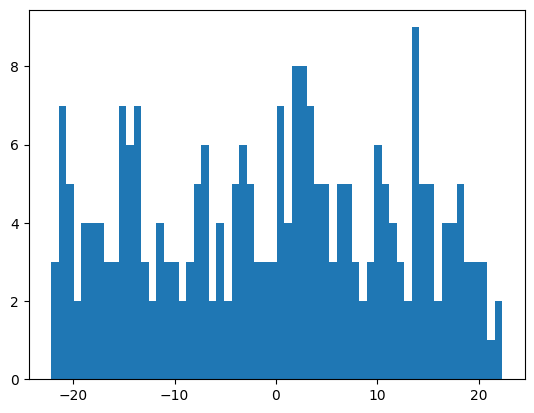

In [180]:
plt.hist(scores, bins = 60)

In [126]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from llm_blender.pair_ranker.pairrm import DebertaV2PairRM # or copy the DebertaV2PairRM definition here, https://github.com/yuchenlin/LLM-Blender/blob/main/llm_blender/pair_ranker/pairrm.py
from transformers import AutoTokenizer
from typing import List
import random
pairrm = DebertaV2PairRM.from_pretrained("llm-blender/PairRM-hf", device_map="cuda:0", cache_dir = model_cache_path).eval()
tokenizer = AutoTokenizer.from_pretrained('llm-blender/PairRM-hf', cache_dir = model_cache_path)
source_prefix = "<|source|>"
cand1_prefix = "<|candidate1|>"
cand2_prefix = "<|candidate2|>"
def tokenize_pair(sources:List[str], candidate1s:List[str], candidate2s:List[str], source_max_length=1224, candidate_max_length=412):
    ids = []
    assert len(sources) == len(candidate1s) == len(candidate2s)
    max_length = source_max_length + 2 * candidate_max_length
    for i in range(len(sources)):
        source_ids = tokenizer.encode(source_prefix + sources[i], max_length=source_max_length, truncation=True)
        candidate_max_length = (max_length - len(source_ids)) // 2
        candidate1_ids = tokenizer.encode(cand1_prefix + candidate1s[i], max_length=candidate_max_length, truncation=True)
        candidate2_ids = tokenizer.encode(cand2_prefix + candidate2s[i], max_length=candidate_max_length, truncation=True)
        ids.append(source_ids + candidate1_ids + candidate2_ids)
    encodings = tokenizer.pad({"input_ids": ids}, return_tensors="pt", padding="max_length", max_length=max_length)
    return encodings
c = candidates[0]
random.shuffle(c)
logits_list = []
n = len(c)
for i in tqdm(range(n//2)):
    inputs = p
    candidates_A = [c[i]]
    candidates_B = [c[i+n//2]]
    encodings = tokenize_pair(inputs, candidates_A, candidates_B)
    encodings = {k:v.to(pairrm.device) for k,v in encodings.items()}
    outputs = pairrm(**encodings)
    logits = outputs.logits.tolist()[0]
    logits_list.append(logits)

100%|██████████| 50/50 [00:04<00:00, 10.96it/s]


In [130]:
np.mean(logits_list)

np.float64(0.3408641266822815)

(array([2., 3., 4., 9., 6., 9., 4., 2., 6., 5.]),
 array([-10.93697166,  -8.77875614,  -6.62054062,  -4.4623251 ,
         -2.30410957,  -0.14589405,   2.01232147,   4.17053699,
          6.32875252,   8.48696804,  10.64518356]),
 <BarContainer object of 10 artists>)

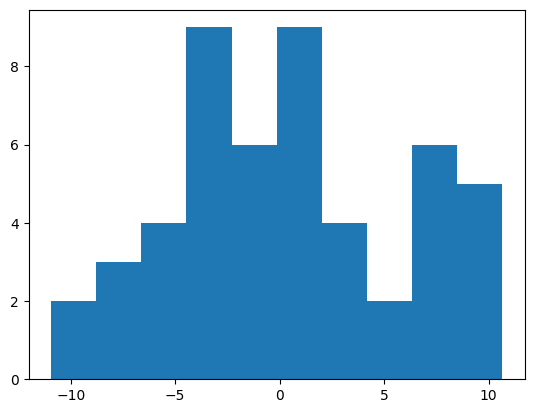

In [129]:
plt.hist(logits_list, bins =10)

In [78]:
sum(np.array(logits_list) < 0)/500

np.float64(0.576)

In [181]:
load_model('Kyleyee/Qwen2.5-1.5B-reward-hh-retrain', task = 'reward', model_type = 'decoder', model_cache_path =  '/workspace/model_cache')

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


(Qwen2ForSequenceClassification(
   (model): Qwen2Model(
     (embed_tokens): Embedding(151936, 1536, padding_idx=151643)
     (layers): ModuleList(
       (0-27): 28 x Qwen2DecoderLayer(
         (self_attn): Qwen2Attention(
           (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
           (k_proj): Linear(in_features=1536, out_features=256, bias=True)
           (v_proj): Linear(in_features=1536, out_features=256, bias=True)
           (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
         )
         (mlp): Qwen2MLP(
           (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
           (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
           (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
           (act_fn): SiLU()
         )
         (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
         (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
       )
     )
     (norm